<a href="https://colab.research.google.com/github/slaninam/MCDA/blob/master/exploratory.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Eploration of crowdsourced measurement data

with map display of relevant values

### Prepare data

Download statistics file from RMBT servers maintained by different regulators, unzip and place in a single folder.

**Output:** folder *data* contains csv files with measurement records, e.g. *CZ.csv*

If file already exists, nothing happens

In [25]:
import pandas as pd
import urllib.request
import zipfile
import os
import shutil

from pathlib import Path

year  = '2019'
month = '09'

links =    {'RTR (AT)': 'https://m-cloud.netztest.at/RMBTStatisticServer/export/netztest-opendata-'+year+'-'+month+'.zip',
            'CTU (CZ)': 'https://control.netmetr.cz/RMBTStatisticServer/export/NetMetr-opendata-'+year+'-'+month+'.zip',
            'HAKOM (HR)': 'https://s01-nettestcs.hakom.hr/export/'+year+'/'+month, # will download .zip
            'ILR (LU)': 'https://s01.checkmynet.lu/export/'+year+'/'+month, # will download .zip
            'Ratel (RS)': 'https://ratel.customers.nettest.org/StatisticServer/export/nettest-opendata-'+year+'-'+month+'.csv', # will download .zip
            'RU (SK)': 'https://s01.meracinternetu.sk/RMBTStatisticServer/export/nettest-opendata-'+year+'-'+month+'.csv', # will download .zip
            'AKOS (SI)': 'https://akos.customers.nettest.org/StatisticServer/export/nettest-opendata-'+year+'-'+month+'.csv' # will download .zip 
            }

datafile = Path('data.zip')

# Specify samples to include
    
os.mkdir('unzipped')
datadir = Path('data')
if not datadir.exists():
    os.mkdir('data')


# Check if data files exist, download if not stored locally
for regulator in links.keys():
    country = (regulator.split(' ')[1].rstrip(')').lstrip('('))
    zipdata = Path(links[regulator])
    csvdata = Path('data/'+country+'.csv')
    
    if not csvdata.exists():
        print('Retrieving data file: ' + links[regulator])
        url = links[regulator]
        #print(url)
        
        urllib.request.urlretrieve(url, 'data.zip')
        with zipfile.ZipFile('data.zip', 'r') as zip_ref:
            zip_ref.extractall(path = 'unzipped')
        os.remove('data.zip')
        
        csvname = next(iter([filename for filename in os.listdir('unzipped') if '.csv' in filename]))
        os.rename('unzipped/'+csvname, 'data/'+country+'.csv')
        
        for filename in os.listdir('unzipped'):
            os.remove('unzipped/'+filename)

os.rmdir('unzipped')    

## Get statistics from downloaded data

### Number of entries per dataset

Currently evaluated for one month.
If useful, can easily be extended to create a timeline over a year or more

<IPython.core.display.Javascript object>


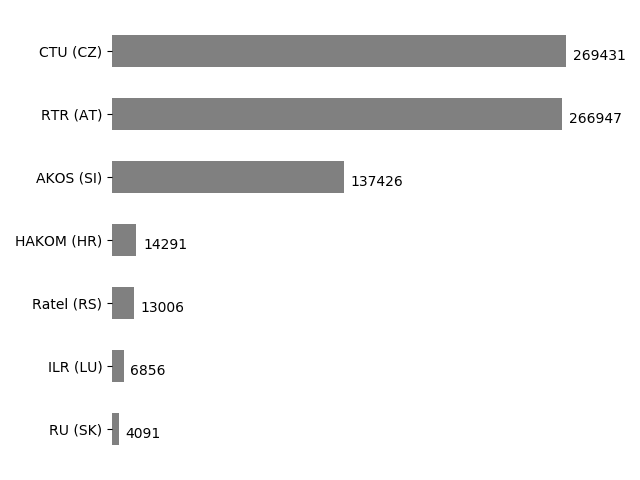

In [132]:
import os
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

%matplotlib notebook

regulators = links.keys()

for regulator in regulators:
    country = regulator.split(' ')[1].rstrip(')').lstrip('(')
    df = pd.read_csv('data/'+country+'.csv')
    sums[regulator] = len(df)

sumsdf = pd.DataFrame.from_dict(sums, orient='index', columns = ['no.entries'])

sumsdf = sumsdf.sort_values(by='no.entries')
fig, ax1 = plt.subplots(1,1)#figsize=(7, 4))

bars = ax1.barh(y=range(len(sumsdf)), width=list(sumsdf['no.entries']), height = 0.5, tick_label=list(sumsdf.index), color='grey')

ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.spines['left'].set_visible(False)
plt.setp(ax1.get_xticklabels(), visible=False)
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
for p in ax1.patches:
    ax1.annotate(str(p.get_width()), (p.get_x() + p.get_width(), p.get_y()), xytext=(5, 5), textcoords='offset points')
plt.tight_layout() # make room for title on the left, otherwise they are partially cut
    
plt.savefig('entries_per_regulator.pdf')

### Fields in the measurement files

It turns out that not all the regulators use the same set of recorded field. The code below produces a table to show what measurement fields are available in each regulator's dataset and what values are found in these fields.

In [184]:
regulators = links.keys()

# read all csv-s into a single data frame. Add 'regulator' column to keep track of the source
dfall = pd.DataFrame()
for regulator in regulators:
    country = regulator.split(' ')[1].rstrip(')').lstrip('(')
    df = pd.read_csv('data/'+country+'.csv')
    df['regulator'] = regulator
    dfall = pd.concat([dfall, df], join='outer', sort='False')

# for each subset, find in which columns there are only NaN values
nans_per_regulator = []
for regulator in regulators:
    nans = ~dfall[dfall['regulator'] == regulator].isnull().all()
    nans_per_regulator.append(nans)

# create a single dataframe from all information, place 'x' to where the parameter is present
table = pd.concat(nans_per_regulator, axis=1)
table.columns = regulators
table.replace(to_replace = False, value = ' ', inplace=True)
table.replace(to_replace = True,  value='x'  , inplace=True)
# get rid of the 'regulator' entry as it was added artificially
table.drop(['regulator'], inplace=True)

# save as LaTeX table
with open('parameters_per_set.tex','w') as texfile:
    table.to_latex(buf=texfile, 
                   column_format='l'+len(table.columns)*'c', 


In [194]:
[column for column in dfall.columns if 'kbit' in column]

['advertised_down_kbit',
 'advertised_up_kbit',
 'deviation_advertised_down_kbit',
 'deviation_advertised_up_kbit',
 'download_kbit',
 'ndt_download_kbit',
 'ndt_upload_kbit',
 'peak_down_kbit',
 'peak_up_kbit',
 'upload_kbit']

In [195]:
len(dfall)

712048

In [196]:
len(dfall.open_test_uuid.unique())

711885